# Ubiquant Market Prediction
Twitch Stream EDA.

1. This notebook was create during a live coding session on twitch. follow for past and future broadcasts here: [here](https://www.twitch.tv/medallionstallion_) 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
from itertools import cycle
import gc
import os

plt.style.use("ggplot")
color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]
#https://qiita.com/skotaro/items/5c9893d186ccd31f459d
color_cycle = cycle(plt.rcParams["axes.prop_cycle"].by_key()["color"])#??

colorstyle example

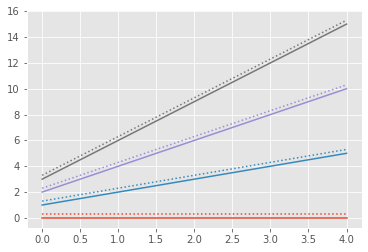

In [2]:
fig = plt.figure()
ax = fig.add_subplot(111)

t = np.arange(5)

for i in range(4):
    ax.plot(t,i*(t+1),   color=color_pal[i], linestyle = '-')
    ax.plot(t,i*(t+1)+.3,color=color_pal[i], linestyle = ':')

plt.show()

In [3]:
os.chdir("../ubiquant/input")

path = os.getcwd()
print(path)

C:\Users\yamap\ubiquant\input


# The Data
Note that the training data is roughly 18.55 Gb in size. This is too large to load into memory directly in kaggle notebook.

Some things to note when exploring the entire dataset on a local machine:
- There are 3579 unique `investment_id`s
- There are 1211 unique `time_id`s - we are told these are not equally spaced and could be different in the test set.
- The features columns are mostly normalized with a mean value close to 0 and standard deviation of ~1.

なお、学習データのサイズは約18.55Gbである。これは、kaggle notebookで直接メモリに読み込むには大きすぎます。

ローカルマシンでデータセット全体を探索する際に注意すべき点がいくつかあります。

- 3579個のユニークな投資IDがあります。
- 1211個のユニークなtime_idsがある - これらは等間隔ではなく、テストセットでは異なる可能性があると言われている。
- 特徴量の列は、平均値が0に近く、標準偏差が〜1と、ほぼ正規化されています。

# Reading the Parquet Version
Reading in csvs can be slow. Instead read from the parquet version here:
- https://www.kaggle.com/robikscube/ubiquant-parquet

In [4]:
train = pd.read_parquet('../input/ubiquant-parquet/train.parquet',
               columns=['time_id','investment_id','target','f_1','f_2','f_3'])
test = pd.read_parquet('../input/ubiquant-parquet/example_test.parquet')
ss = pd.read_parquet('../input/ubiquant-parquet/example_sample_submission.parquet')

In [5]:
unique_time_ids = train['time_id'].nunique()
unique_inv_ids = train['investment_id'].nunique()

print(f'There are {unique_inv_ids} unique investment ids and {unique_time_ids} unique time ids')

There are 3579 unique investment ids and 1211 unique time ids


In [6]:
train.head()

,time_id,investment_id,target,f_1,f_2,f_3
0,0,1,-0.300875,0.113691,-0.402206,0.378386
1,0,2,-0.231040,-0.514115,0.742368,-0.616673
2,0,6,0.568807,0.615937,0.567806,-0.607963
3,0,7,-1.064780,-0.011870,1.874606,-0.606346
4,0,8,-0.531940,-0.262993,2.330030,-0.583422


## Read in a single invesment_id (investment_id == 1)

In [7]:
example = pd.read_parquet('../input/ubiquant-parquet/investment_ids/1.parquet')
example.head()

,row_id,time_id,investment_id,target,f_0,f_1,f_2,f_3,f_4,f_5,...,f_290,f_291,f_292,f_293,f_294,f_295,f_296,f_297,f_298,f_299
0,0_1,0,1,-0.300875,0.932573,0.113691,-0.402206,0.378386,-0.203938,-0.413469,...,0.366028,-1.095620,0.200075,0.819155,0.941183,-0.086764,-1.087009,-1.044826,-0.287605,0.321566
2272,1_1,1,1,-0.917045,0.373575,0.296349,0.019102,-0.031842,-0.222027,-0.199950,...,0.235071,-1.081652,0.645607,0.581035,0.839101,-0.362388,1.229239,-1.301037,-0.391490,0.330331
4547,2_1,2,1,-0.480234,-0.834696,0.305233,0.057615,-0.193257,-0.174489,0.220638,...,0.069175,-1.283087,0.416513,0.733835,0.708725,-0.318409,1.307892,-0.863906,-0.478679,0.291295
6822,3_1,3,1,-0.323562,0.351200,0.223923,0.180545,-0.539181,-0.189680,1.441749,...,-0.105696,-1.263037,0.178360,0.766542,0.442616,-0.106181,1.409676,-0.230144,-0.375909,0.249669
9107,4_1,4,1,2.494479,0.524965,0.076604,-0.102443,-0.527988,-0.185988,2.290313,...,0.988886,-0.582876,0.215926,0.469335,-0.569905,-0.365051,-0.614434,-0.254252,-0.272463,0.299061


In [8]:
example.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1108 entries, 0 to 3137973
Columns: 304 entries, row_id to f_299
dtypes: float64(301), int64(2), object(1)
memory usage: 2.6+ MB


In [9]:
example.isnull().sum()

row_id           0
time_id          0
investment_id    0
target           0
f_0              0
                ..
f_295            0
f_296            0
f_297            0
f_298            0
f_299            0
Length: 304, dtype: int64

In [19]:
train.isnull().sum()

time_id          0
investment_id    0
target           0
f_1              0
f_2              0
f_3              0
dtype: int64

# Train Data Fields

tl;dr - we have time series data but don't know the exact time periods being provided. We also have investment_ids that are not unique. Everything is anonymized so it's not easy to create features.

- `row_id` - A unique identifier for the row.
- `time_id` - The ID code for the time the data was gathered. The time IDs are in order, but the real time between the time IDs is not constant and will likely be shorter for the final private test set than in the training set.
- `investment_id` - The ID code for an investment. Not all investment have data in all time IDs.
- `target` - The target.
- `features` - [f_0:f_299] - Anonymized features generated from market data.


tl;dr - 時系列データを持っていますが、提供されている正確な期間を知りません。また、一意でないinvestment_idも持っています。すべてが匿名化されているので、特徴を作るのは簡単ではありません。

- row_id` - その行の一意な識別子。
- time_id` - データが収集された時刻の ID コード。時間IDは順番に並んでいますが、時間ID間の実時間は一定ではなく、最終的なプライベートテストセットではトレーニングセットよりも短くなる可能性が高いです。
- `investment_id` - 投資のIDコード。すべての投資家がすべての時間IDにデータを持っているわけではありません。
- target` - ターゲット。
- features` - [f_0:f_299] - マーケットデータから生成された匿名化された特徴量。

# Example Target for some investment ids

In [10]:
id_0 = train["investment_id"] == 0
train[id_0]

,time_id,investment_id,target,f_1,f_2,f_3
1711316,757,0,0.066664,4.222316,0.000000,7.042030
1714085,758,0,2.788548,4.151623,0.000000,6.618785
1716869,759,0,-3.844462,3.846268,0.000000,6.281942
1719651,760,0,-3.304178,3.549768,0.000000,6.268737
1722426,761,0,-3.440455,2.754384,0.000000,5.847007
...,...,...,...,...,...,...
3124270,1215,0,0.579622,0.752708,-1.806642,0.653839
3127702,1216,0,0.064896,0.380909,-0.542145,1.036327
3131120,1217,0,2.204664,-0.023446,-1.424204,0.946071
3134540,1218,0,1.037581,-0.211851,-2.325953,0.945858


In [18]:
time_d = train["time_id"] == 211
c = train[time_d]
c.count()

time_id          2265
investment_id    2265
target           2265
f_1              2265
f_2              2265
f_3              2265
dtype: int64

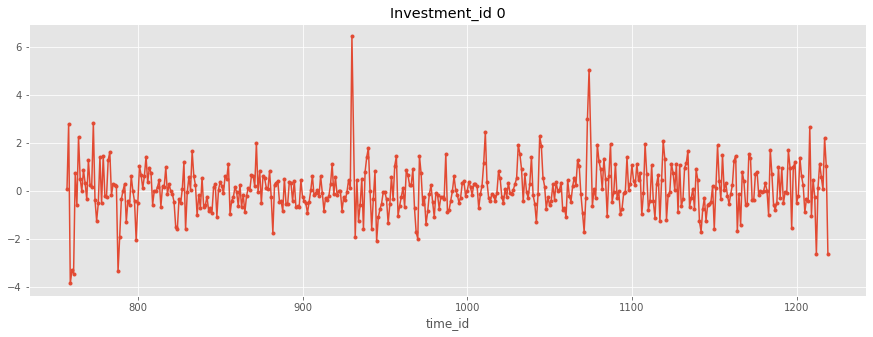

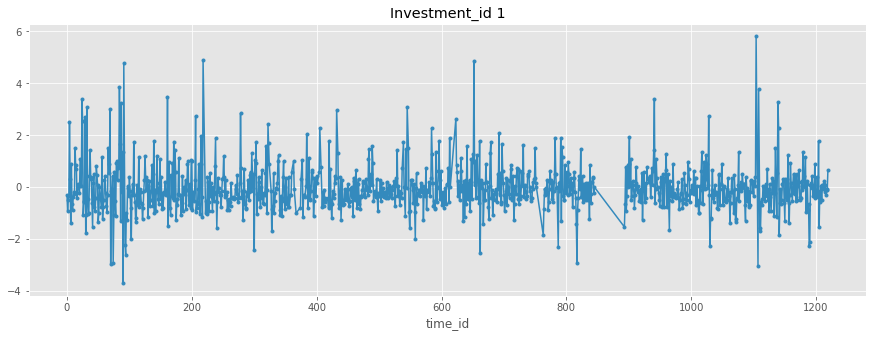

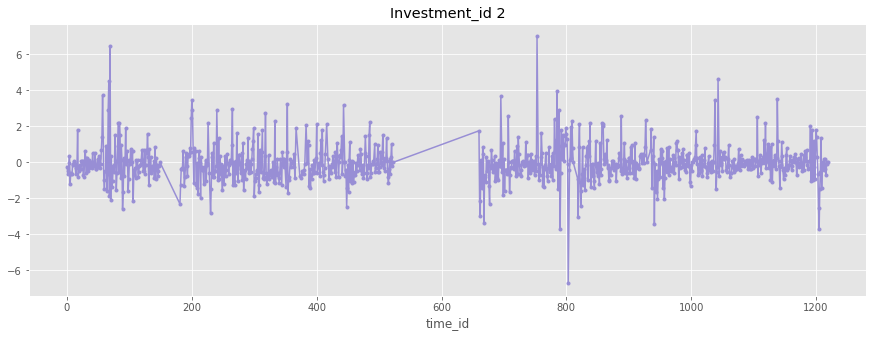

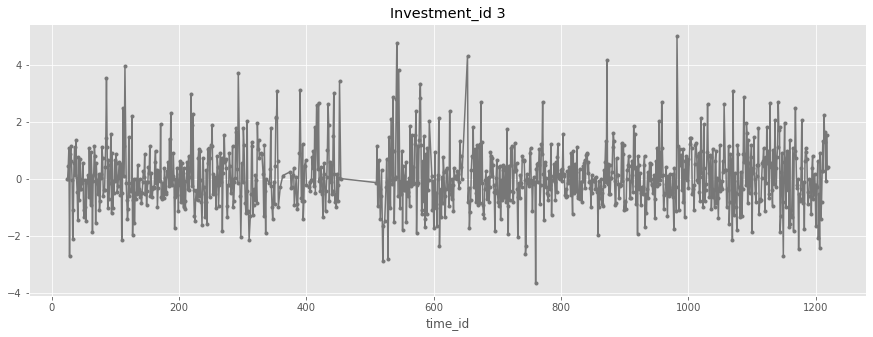

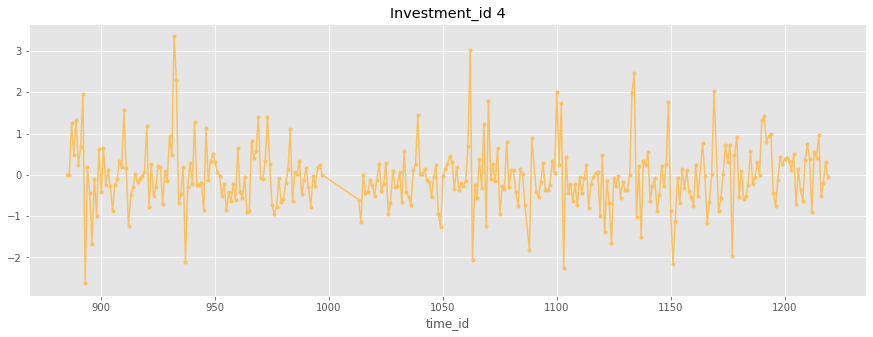

In [11]:
for investment_id in range(5):
    d = train.query('investment_id == @investment_id')
    d.set_index('time_id')['target'] \
        .plot(figsize=(15, 5),
              title=f'Investment_id {investment_id}',
              color=next(color_cycle),
              style='.-')
    plt.show()

# Example of Features for a Single Investment ID
- We are only looking at 3 of the features.

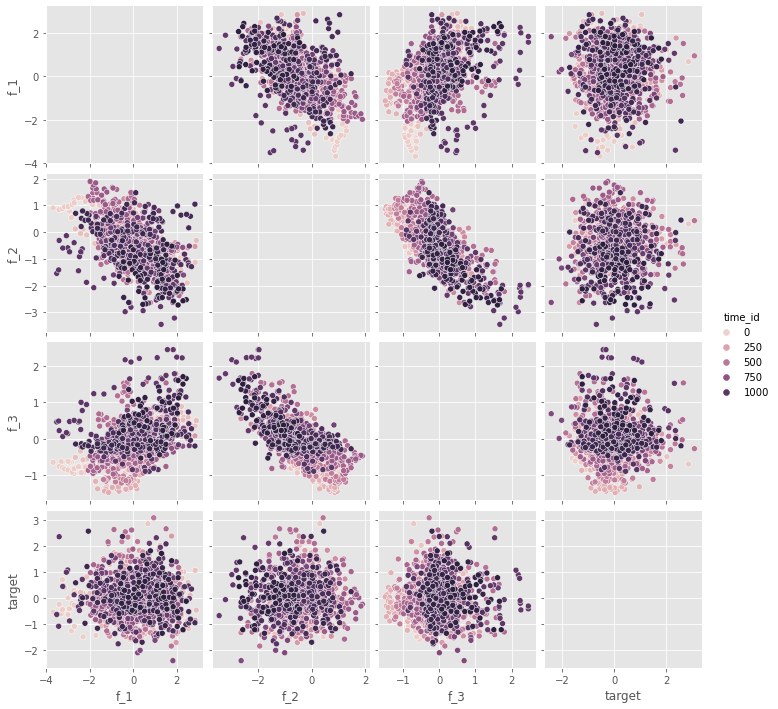

In [12]:
example_id = train.query('investment_id == 529')
sns.pairplot(example_id,
             vars=['f_1','f_2','f_3','target'],
            hue='time_id')

# Make Some Dummy Predictions

In [15]:
# Take the last 50 known targets for each invesment_id and predict as the mean
inv_pred_dict = train.groupby('investment_id') \
    .tail(50).groupby('investment_id')['target'].mean().to_dict()

# How to Make Predictions

In [14]:
import ubiquant
env = ubiquant.make_env()
iter_test = env.iter_test()
for (test_df, spdf) in iter_test:
    spdf['target'] = test_df['investment_id'].map(inv_pred_dict)
    env.predict(spdf)

ModuleNotFoundError: No module named 'ubiquant'